## In this notebook, amplicon data will be imported as raw read counts and each ASV occurrence will be modeled as a probability distribution. Samples will then be clustered based on their overall community composition.

### Import all the dependencies

In [1]:
import os
import pandas as pd
import numpy as np
import subprocess

### Move to working directory

In [2]:
os.chdir('/Users/nastassia.patin/GitHub/NOAA-NCAR-Hackathon')

### 01. This section imports the amplicon data as raw counts and calls an R script to model the ASV occurrence as a probability distribution. 

#### Import example amplicon data sheet and take a look

In [3]:
file = 'Data/Flyer2018_16S_table_counts.tsv'
asvs = pd.read_csv(file, index_col=0, sep='\t')
asvs

,CN18Fc12_8_eDNA,CN18Fc19_5_eDNA,CN18Fc21_6_eDNA,CN18Fc22_6_eDNA,CN18Fc24_6_eDNA,CN18Fc25_5_eDNA,CN18Fc27_4_eDNA,CN18Fc29_6_eDNA,CN18Fc30_4_eDNA,CN18Fc32_4_eDNA,...,CN18SESPkoa_SC36,CN18SESPkoa_SC37,CN18SESPkoa_SC39,CN18SESPkoa_SC40,CN18SESPkoa_SC41,CN18SESPkoa_SC42,CN18SESPkoa_SC44,CN18SESPkoa_SC45,CN18SESPkoa_SC47,CN18SESPkoa_SC49
ASV ID,,,,,,,,,,,,,,,,,,,,,
495c1bd1608a1dad54d3e2824ce899ef,552,7415,8749,8152,7124,12422,215,8080,8799,2231,...,4324,1339,95,1554,147,2720,21,2015,1847,1886
a900b6678ce86851fb16bfafb87f3326,210,1933,2808,1967,1671,4912,57,3688,3343,1134,...,21023,8898,1367,8291,1112,9881,60,8726,9330,8852
c8e360969108fa2125a3d56eb4dad24f,145,2089,2530,2086,2343,2395,129,1625,1664,639,...,4830,9,566,20,551,60,43,22,28,44
72143fd9e63fe40c1258948d2f0d79c3,130,1830,2516,2178,2256,3332,56,2535,2316,629,...,4227,83,512,75,497,154,48,97,116,80
7b6b178fad5599c0e9a734e4fb09fd64,156,1742,1761,1855,1812,2467,73,1663,1612,515,...,2385,47,287,45,520,104,50,57,72,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674933a0d44342a0647f7a5b4591f26e,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bebe1b9a7e9aaa78172c1208111f4570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0128431733f67d02efad766d717fe6fd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Call the R script to model the ASV count distributions

#### Function to run R program on input data given the file name

In [48]:
def call_Rscript_for_amplicon_modeling(path, sample_num, arg1):
    # Use subprocess.Popen to open executable Rscript and extract stdout from 'print' command in R
    with subprocess.Popen(['Rscript', path, '--args', '--vanilla', arg1], 
                          stdout=subprocess.PIPE) as result:
        asvs_freq = result.stdout.read()
    
    # The R output gets imported as "bytes"; need to convert to string
    y = asvs_freq.decode("utf-8")
    y = y.replace(",", "").split()

    # remove the column and row headers
    z = [ x for x in y if "[" not in x ]

    # Convert to numpy array
    array = np.asarray(z)
    # Reshape to original dimensions; number of samples (columns) is second field, 
    # unknown number of ASVs can be supplied with '-1'
    mat = np.reshape(array, (-1, sample_num))

    # Convert to data frame with sample names as columns
    names = np.arange(1, sample_num+1, 1)
    df = pd.DataFrame(mat, columns=names)
    df = df.astype(float)
    return(df)

#### Define arguments

In [58]:
path_to_rscript = '/Users/nastassia.patin/GitHub/NOAA-NCAR-Hackathon/ranRelPct_testdata.R'
data_file_name = 'Flyer2018_18S_table_counts.tsv'
number_of_samples = 63

In [59]:
asvs_modeled = call_Rscript_for_amplicon_modeling(path_to_rscript, 
                                                  number_of_samples, 
                                                  data_file_name)

In [60]:
asvs_modeled

,1,2,3,4,5,6,7,8,9,10,...,54,55,56,57,58,59,60,61,62,63
0,0.000184,0.000108,0.000059,0.006924,0.000006,7.722356e-05,0.000015,0.000046,0.000001,0.000003,...,0.000090,0.005344,0.002161,0.000377,0.000076,0.000111,0.000358,0.000380,0.000009,0.000034
1,0.000057,0.000737,0.000038,0.000004,0.000015,4.807215e-06,0.000007,0.000008,0.000015,0.000004,...,0.000019,0.000008,0.000003,0.000004,0.006319,0.001175,0.000911,0.001628,0.005475,0.000003
2,0.000012,0.000001,0.000017,0.000002,0.004827,1.872820e-03,0.004293,0.003965,0.012772,0.007188,...,0.000019,0.000027,0.000004,0.000034,0.000004,0.000026,0.000832,0.000311,0.000549,0.001196
3,0.008701,0.000015,0.000089,0.000013,0.000037,4.339198e-06,0.003783,0.000412,0.000711,0.000192,...,0.000072,0.000012,0.000033,0.000006,0.000023,0.000006,0.000011,0.000091,0.000097,0.000012
4,0.000006,0.000012,0.000031,0.000119,0.000061,7.396701e-05,0.000177,0.000272,0.000027,0.000023,...,0.000027,0.000019,0.000001,0.000006,0.000005,0.007596,0.001486,0.001396,0.001706,0.004097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380,0.000008,0.000019,0.000054,0.000012,0.000009,2.407602e-05,0.000071,0.000049,0.000145,0.000005,...,0.000044,0.000157,0.000014,0.000084,0.000086,0.000090,0.000032,0.000074,0.000034,0.000003
7381,0.000088,0.000046,0.000002,0.000052,0.000075,1.435835e-04,0.000065,0.000011,0.000025,0.000008,...,0.000023,0.000087,0.000071,0.000015,0.000100,0.000018,0.000017,0.000021,0.000020,0.000011
7382,0.000052,0.000028,0.000132,0.000052,0.000007,4.055546e-05,0.000028,0.000005,0.000001,0.000263,...,0.000090,0.000003,0.000064,0.000286,0.000006,0.000046,0.000014,0.000060,0.000056,0.000117
7383,0.000048,0.000030,0.000004,0.000021,0.000013,9.410681e-07,0.000099,0.000022,0.000084,0.000130,...,0.000009,0.000003,0.000003,0.000096,0.000062,0.000013,0.000056,0.000009,0.000009,0.000097


## 02. Use the modeled counts table generated in [01] to reduce dimensionality and visualize principal components

In [61]:
from sklearn.decomposition import PCA
import seaborn as sns

#### Log-transform data for Euclidean distances

In [62]:
df = np.log10(asvs_modeled)

#### From untransformed matrix

In [63]:
pca = PCA(n_components=10)
pca.fit_transform(asvs_modeled)
pca.explained_variance_ratio_.cumsum()

array([0.12263804, 0.23022707, 0.31551521, 0.39763364, 0.47180215,
       0.52622836, 0.58044831, 0.62714644, 0.66913573, 0.70185967])

#### From log-transformed matrix

In [64]:
pca = PCA(n_components=10)
pca.fit_transform(df)
pca.explained_variance_ratio_.cumsum()

array([0.17323358, 0.20193794, 0.2295079 , 0.25674291, 0.28211485,
       0.30679387, 0.33094744, 0.35281114, 0.37412556, 0.39355124])

### We can see that log-transforming the data causes dimensionality reduction to explain even less of the variance than untransformed data. Moreover, even 10 components of the untransformed PCA don't explain most of the variance (max 67%). We'll have to work on this going forward.

<AxesSubplot:>

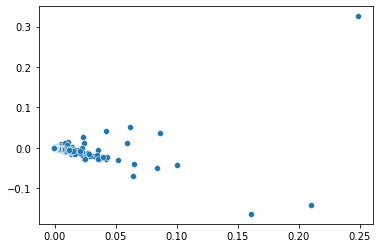

In [65]:
ca = PCA(n_components=2)
pcs = pca.fit_transform(asvs_modeled)

pc1_values = pcs[:,0]
pc2_values = pcs[:,1]
sns.scatterplot(x=pc1_values, y=pc2_values)

## 03. Performing hierarchical clustering: default SciPy model

In [67]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

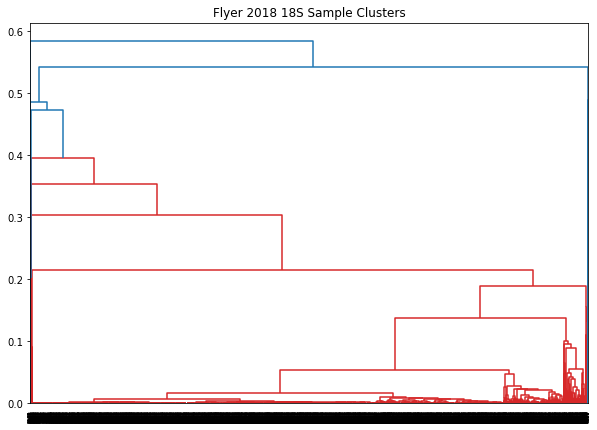

In [68]:
plt.figure(figsize=(10, 7))
plt.title("Flyer 2018 18S Sample Clusters")

# Make the clusters
clusters = shc.linkage(pcs, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

## 04. Performing hierarchical clustering: create an agglomerative hierarchical clustering model with Scikit-Learn

In [69]:
pcs_select = pd.DataFrame(pcs)
pcs_select = pcs_select.iloc[:, 0:2]
pcs_select = pcs_select.set_axis(['PC_1', 'PC_2'], axis=1, inplace=False)
pcs_select

,PC_1,PC_2
0,0.032211,-0.019071
1,0.001109,-0.000664
2,0.003151,-0.002936
3,0.000856,-0.000932
4,0.000268,-0.000231
...,...,...
7380,-0.000504,0.000235
7381,-0.000490,0.000042
7382,-0.000521,0.000195
7383,-0.000505,0.000220


In [70]:
from sklearn.cluster import AgglomerativeClustering

In [71]:
clustering_model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
clustering_model.fit(pcs_select)
clustering_model.labels_

array([0, 1, 1, ..., 1, 1, 1])

Text(0.5, 1.0, 'Flyer 2018 18S Samples')

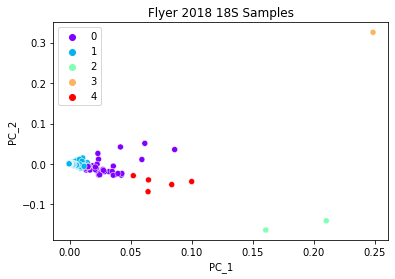

In [72]:
data_labels = clustering_model.labels_
sns.scatterplot(data=pcs_select, 
                x='PC_1',
                y='PC_2',
                hue=data_labels,
                palette="rainbow").set_title('Flyer 2018 18S Samples')

### EXTRA NOTE: Below is something I did for a k-means analysis once; it was a useful way of determining how many clusters are informative. Need to figure out how to do this with hierarchical clustering.

#### Determine how many clusters are most informative. Once the line starts to level out, more clusters become less useful.

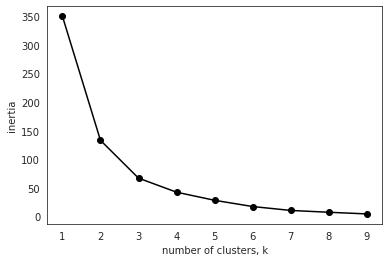

In [233]:
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()